In [1]:
#load in lightcurve data

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import sem

lightcurve = pd.read_csv('student_004.txt', header = None, delimiter = ' ')
lightcurve = lightcurve.rename(columns={0: 'time', 1: 'brightness'})

lightcurve

,time,brightness
0,0.000000e+00,0.999981
1,1.687471e+02,1.000011
2,3.374943e+02,0.999440
3,5.062414e+02,0.998814
4,6.749886e+02,0.997945
...,...,...
70395,1.187896e+07,0.999815
70396,1.187912e+07,1.000046
70397,1.187929e+07,1.000140
70398,1.187946e+07,0.999869


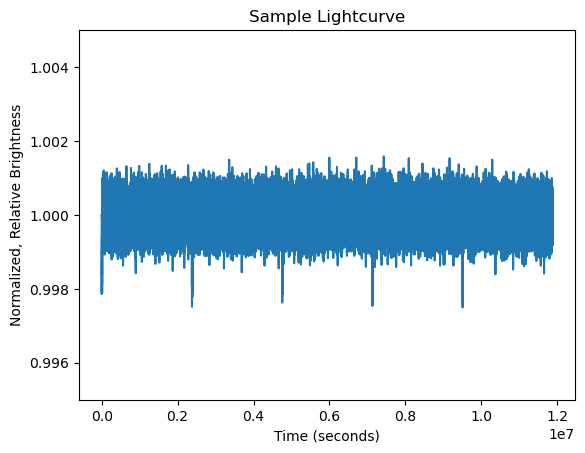

In [3]:
import matplotlib.pyplot as plt

plt.plot(lightcurve['time'], lightcurve['brightness'])
plt.ylim(0.995, 1.005)
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized, Relative Brightness')
plt.title('Sample Lightcurve')
plt.show()

# Finding Period

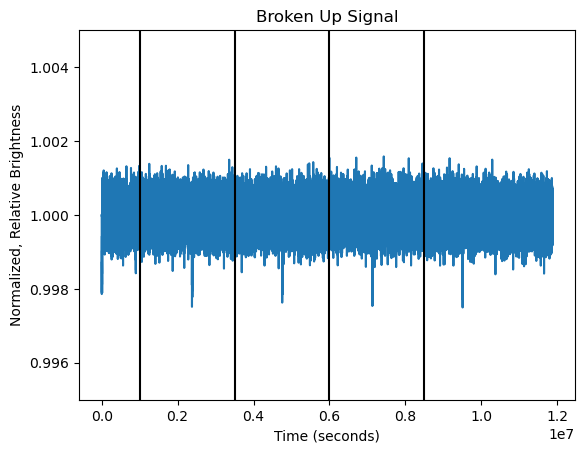

In [4]:
#split data to chunks, where each block contains a transit

divides = [0.1e7, 0.35e7, 0.6e7, 0.85e7]

import matplotlib.pyplot as plt

plt.plot(lightcurve['time'], lightcurve['brightness'])
for i in divides:
    plt.axvline(x = i, color = 'k')
plt.ylim(0.995, 1.005)
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized, Relative Brightness')
plt.title('Broken Up Signal')
plt.show()

In [5]:
#for each chunk, find where minimum occurs

index_slices = []
#find index where each 'divide' occurs

#size of dx
dx = lightcurve['time'][3] - lightcurve['time'][2]

#start time
t0 = lightcurve['time'][0]

#thus, index where divide occurs is
index_slices = [int((i - t0) / dx) for i in divides]


#now, seperate data into chunks
b1 = np.array(lightcurve['brightness'][:index_slices[0]])
t1 = np.array(lightcurve['time'][:index_slices[0]])

b2 = np.array(lightcurve['brightness'][index_slices[0]:index_slices[1]])
t2 = np.array(lightcurve['time'][index_slices[0]:index_slices[1]])

b3 = np.array(lightcurve['brightness'][index_slices[1]:index_slices[2]])
t3 = np.array(lightcurve['time'][index_slices[1]:index_slices[2]])

b4 = np.array(lightcurve['brightness'][index_slices[2]:index_slices[3]])
t4 = np.array(lightcurve['time'][index_slices[2]:index_slices[3]])

b5 = np.array(lightcurve['brightness'][index_slices[3]:])
t5 = np.array(lightcurve['time'][index_slices[3]:])

In [6]:
#now, find the time corresponding to the minimum of each chunk

for index, element in enumerate(b1):
    if element == min(b1):
        min1 = t1[index]
        index1 = index

for index, element in enumerate(b2):
    if element == min(b2):
        min2 = t2[index]
        index2 = index
        
for index, element in enumerate(b3):
    if element == min(b3):
        min3 = t3[index]
        index3 = index
        
for index, element in enumerate(b4):
    if element == min(b4):
        min4 = t4[index]
        index4 = index
        
for index, element in enumerate(b5):
    if element == min(b5):
        min5 = t5[index]
        index5 = index

minimums = [min1, min2, min3, min4, min5]
    

In [7]:
minimums

[2193.7128922, 2378491.0165, 4755969.5502, 7131254.371, 9508226.6632]

# Period Calculation

In [8]:
#period calculation

period = np.mean([min5 - min4, min4 - min3, min3 - min2, min2 - min1])
period = period / (60 * 60 * 24)

#finding error for the period

perror = [min5 - min4, min4 - min3, min3 - min2, min2 - min1]
perror = [i / (60 * 60 * 24) for i in perror]

error_period = sem(perror)


print('period:', round(period, 2), '+-', round(error_period,2), 'days')

period: 27.51 +- 0.01 days


# Folding Transits

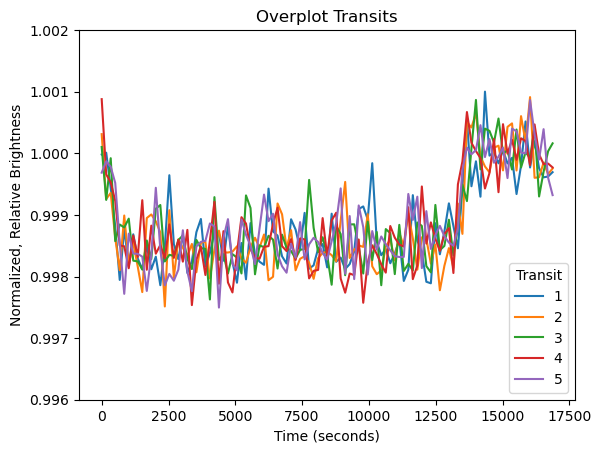

In [9]:
#if we know that each transit is ~13500 seconds, then we can extract each transit by
#slicing ~8000 seconds in each direction from the minimum (so we also include a baseline brightness)

#while this is technically giving us a transit centered around its minima rather than the start, 
#we can then roll the data over to match it to the beginning.

#convert 8000 seconds to index
buffer_left = int(2500 / dx)
buffer_right = int(15000 / dx)

transit1 = np.array(b1[:index1 + buffer_right])
time1 = np.array(t1[:index1 + buffer_right])

transit2 = np.array(b2[index2 - buffer_left : index2 + buffer_right -1])
time2 = np.array(t2[index2 - buffer_left : index2 + buffer_right -1])

transit3 = np.array(b3[index3 - buffer_left -10 : index3 + buffer_right - 11])
time3 = np.array(t3[index3 - buffer_left - 10 : index3 + buffer_right - 11])

transit4 = np.array(b4[index4 - buffer_left -6: index4 + buffer_right -7])
time4 = np.array(t4[index4 - buffer_left -6 : index4 + buffer_right -7])

transit5 = np.array(b5[index5 - buffer_left -12 : index5 + buffer_right - 13])
time5 = np.array(t5[index5 - buffer_left -12 : index5 + buffer_right - 13])

plt.plot(time1, transit1)
plt.plot(time1, transit2)
plt.plot(time1, transit3)
plt.plot(time1, transit4)
plt.plot(time1, transit5)

plt.legend(labels = ['1', '2', '3', '4', '5'], title = 'Transit')
plt.ylim(0.996, 1.002)
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized, Relative Brightness')
plt.title('Overplot Transits')

plt.show()

## Calculating Depth

In [10]:
#cut off transits to only include full depth (when planet is entirely infront of star)

s1 = 7; s2 = 78 #slices where transit is at full depth

brightness_depth = list(transit1[s1:s2]) + list(transit2[s1:s2]) + list(transit3[s1:s2]) + list(transit4[s1:s2]) + list(transit5[s1:s2])

#now, we find the average value in the section where there is no transit to get a baseline brightness
np.mean(lightcurve['brightness'][100:12000])

0.9999965246605823

In [11]:
## This value makes sense since we are using a normalized, relative brightness. Because of this, we will use
#a value of 1 for the 'baseline' brightness.

#thus, the depth is 
depth = 1 - np.mean(brightness_depth)

#finding standard error of the mean
error_depth = sem(brightness_depth)


print('Transit blocks', round(depth*100,3), '+-', round(error_depth*100,3), '% of the stars light')

Transit blocks 0.152 +- 0.002 % of the stars light


# Radius Calculation

### We know that the radius of the star is Rstar = 0.545 Rsun, and that the radius of an exoplanet is given by (delta f/ f) = (Rb / Ra)^2

In [12]:
#also, given that
Rstar = 0.545 #Rsun

#thus
R_exoplanet = np.sqrt(depth) * Rstar #Rsun

#convert to m
R_exoplanet = R_exoplanet * 6.995 * (10**8) #meters

#convert to earth Radii
R_exoplanet = R_exoplanet / (6.378e6) #earth radii

In [13]:
#Error propagation

Mstar = 0.568 #Msun
Mplanet = 9.243 #Mearth

error_Rstar = Rstar * 0.05
error_Mstar = Mstar * 0.05
error_Mplanet = Mplanet * 0.05

#Error in radius calculation:

#using delta_z / z = sqrt( (m*delta_x/x)^2 + (n*delta_y/y)^2 ) for z = x^m * y*n

error_radius = R_exoplanet * np.sqrt( (0.5*error_depth/depth)**2 + (error_Rstar/Rstar)**2  )


print('Exoplanet Radius = ', round(R_exoplanet,1), '+-', round(error_radius,1), 'Earth Radii')

Exoplanet Radius =  2.3 +- 0.1 Earth Radii


# Transit Time

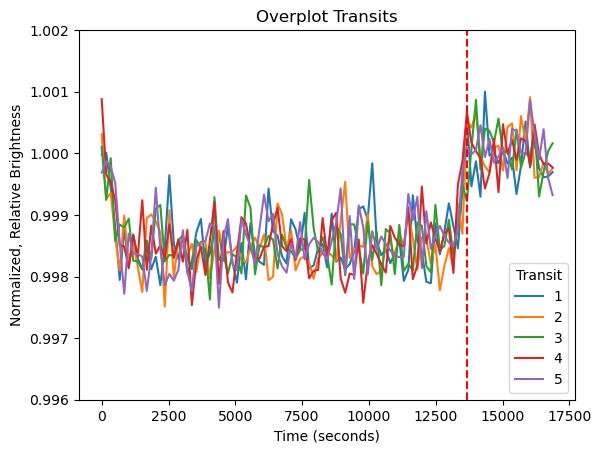

In [14]:
#visually plotting where transit ends

plt.plot(time1, transit1)
plt.plot(time1, transit2)
plt.plot(time1, transit3)
plt.plot(time1, transit4)
plt.plot(time1, transit5)

plt.axvline(time1[81], color='r', linestyle='--')

plt.legend(labels = ['1', '2', '3', '4', '5'], title = 'Transit')
plt.ylim(0.996, 1.002)
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized, Relative Brightness')

plt.title('Overplot Transits')

plt.show()



In [15]:
#my transit begins at bin 0 and ends at bin 81. If we are accurate to one bin, then our error is
#converting to minutes and hours

transit_time = time1[81] / (60 * 60)
error_time = (time1[81] - time1[80]) / 60

print('Transit Time = ', round(transit_time,1), 'Hours', '+-', round(error_time,1), 'Minutes')


Transit Time =  3.8 Hours +- 2.8 Minutes


# aB

In [38]:
##### If we know the period, we can use keplar's third law to calculate the semi-major axis.
#notaby, p^2 = a^3 in years and AU.

period_years = period / 365.25

aB = period_years ** (2/3)

#error calculation
error_period_years = error_period / 365.25

error_aB = np.sqrt( ((3/2) * error_period_years / period_years) **2 )

print('Planet Semi Major Axis = ', round(aB,3), '+-', round(error_aB,4), 'AU')

Planet Semi Major Axis =  0.178 +- 0.0003 AU


# aA

In [39]:
# aB / aA = Ma / Mb

# -> aA = aB * (Mb / Ma)

aA = aB * ((Mplanet * 3.0027e-6) / Mstar) #converting to M sun

error_aA = np.sqrt( (error_aB/aB)**2 + (error_Mstar / Mstar)**2 + (error_Mplanet / Mplanet)**2)

print('Star Semi Major Axis = ', round(aA,5), '+-', round(error_aA,3), 'AU')

Star Semi Major Axis =  1e-05 +- 0.071 AU


# vB

In [18]:
#in the case where planet is much less massive than star, aB given by keplar's third law and speed is:
#vB = (2 pi aB / P) = 30 km/s (Ma / 1 M sun)^1/3 (P / 1 yr)^ -1/3

vB = 30 * ((Mstar)**(1/3)) * ((period_years)**(-1/3))

error_vB = np.sqrt( ((1/3)*error_Mstar/Mstar)**2 + ((-1/3)*error_period_years/period_years)**2 )

print('Planet Velocity = ', round(vB,2), '+-', round(error_vB,2), 'km / s')

Planet Velocity =  58.83 +- 0.02 km / s


# vA

In [41]:
#using vA / vB = aA / aB: 
#(this also works using vA/vB = Mb / Ma; checked to make sure all values are consistent)

vA = vB * (Mplanet* 3.0027e-6 / Mstar)

error_vA = np.sqrt( (error_vB/vB)**2 + (error_Mplanet / Mplanet)**2 + (error_Mstar / Mstar)**2)

print('Star Velocity = ', round(vA,3), '+-', round(error_vA,2), 'km / s')



Star Velocity =  0.003 +- 0.07 km / s


# i 

In [20]:
#since we detected this exoplanet through the transit method, i must be very close to 90 degrees.

#in fact, using cos(i) < 0.0046 (Ra + Rb) / Rsun * (1 AU / a)

cosi = 0.0046 * Rstar * aB

i = np.arccos(cosi) * 180 / np.pi

# we see that i is very close to 90 degrees (as expected). In fact,

error_i = i - (np.arccos(0.0046 * (Rstar+error_Rstar) * aB) * 180 / np.pi)

print('i ~ ', round(i,3), '+-', round(error_i,3), 'Degrees')



i ~  89.974 +- 0.001 Degrees


# Density

In [21]:
#Given mass and radius, we can calculate the density of the planet by assuming a perfect sphere

#convert to SI units too

Vplanet = 4/3 * np.pi * ((R_exoplanet*6.378e6)**3)

density = (Mplanet*5.972e+24) / Vplanet 

error_density = density * np.sqrt((error_Mplanet / Mplanet)**2 + (error_radius / R_exoplanet)**2)


print('Planet Density = ', round(density-4), '+-', round(error_density), 'Kg / m^3')

Planet Density =  4020 +- 286 Kg / m^3


# Temperature

In [34]:
#given that our planet is so close to its star, we can assume that it will be a slow rotator
#as it is likely tidally locked. 

#we do not know the temperature of the star; however, given that the radius and mass of the star
#is ~50% that of our sun, it is likely between a K and M type star. 
#Using this, we will assume a temperature of 4000 K

Tstar = 4000

#for albedo, we will use the fact that our planet is rocky in composition to 'guess' an albedo of 0.1-0.5.
#this is assuming that there is no significant contribution from an atmosphere
#this gives us an upper and lower limit of:

albedo_low = 0.1
albedo_high = 0.5

temp_low = ((Rstar*0.00465047) / aB)**(1/2) * (1-albedo_low)**(1/4) * Tstar
temp_high = ((Rstar*0.00465047) / aB)**(1/2) * (1-albedo_high)**(1/4) * Tstar

print('Planet Temperature: ~', int(round((temp_low + temp_high)/2,-2)), 'K')

Planet Temperature: ~ 400 K


## classifying:

most similar to 

Kepler-267 d

- detected 2014 by transit method
- orbital period: 28.46381±0.00028
- Orbit Semi-Major Axis .15
- Planet Radius [Earth Radius] 2.31±0.63
- Equil. Temp: 337 K

Its host star (Keplar 875) has:

- Stellar Effective Temperature 4081.00±200.00
- Stellar Radius [Solar Radius] 0.5270±0.0290
- Stellar Mass [Solar mass] 0.5520±0.0380
